## Campos involucrados

- titulo
- descripcion

## Ideas

- wordcloud
- normalizacion
- stemming
- palabras positivas (respecto al precio)
- palabras negativas (respecto al precio)

## Hipótesis

- ciertas palabras indican mayor precio (luminoso, jardín, hermoso, vista...)
- a más palabras, mayor precio

## Resultados
- la correlacion entre longitud de descripcion y precio es bastante baja (0.1)
- la correlacion entre la cantidad de palabras positivas en la descripcion y el precio es bastante alta (0.3) [tener en cuenta que metrostotales tiene correlacion 0.5]

In [2]:
#importo las funciones para levantar los dataframes
%run "../../utils/dataset_parsing.ipynb"
#importo las funciones para graficar
%run "../../utils/graphs.ipynb"
df = levantar_datos("../../"+DATASET_RELATIVE_PATH)
df.columns
pd.set_option("display.max_colwidth", -1)

In [3]:
pd.set_option("display.max_columns", 50)

In [4]:
import nltk  
from nltk.corpus import stopwords  
from string import punctuation  

In [5]:
spanish_stopwords = set(stopwords.words('spanish'))
non_words = set(punctuation)
non_words.update({'¿', '¡'})
non_words.update(map(str,range(10)))

In [6]:
import re
from unidecode import unidecode

def is_meaningful(word: str) -> bool:
    """
        Recibe una palabra, remueve puntuaciones y verifica que lo que queda no esté en el set de stopwords
    """
    return len(word) > 2 and not word in spanish_stopwords

def remove_html(field: str) -> str:
    """
        Recibe un texto y devuelve una copia sin los tags html
    """
    return re.compile(r'<[^>]+>').sub('', field) if field else field

def normalize(field: str) -> str:
    """
        Recibe un texto y devuelve una copia sin acentos, ñ ni puntuaciones.
    """
    return ''.join([" " if c in non_words else unidecode(c) for c in field]).strip() if field else ""

def limpiar_campo(field: str) -> str:
    """
        Recibe un campo string que podría tener muchas palabras.
        Devuelve un string que contiene sólo las palabras significativas.
    """
    if not isinstance(field,str): return ""
    without_html = remove_html(field)
    normalized = normalize(without_html)
    meaningful = " ".join(set(filter(is_meaningful, normalized.split())))
    return meaningful

In [7]:
df["descripcion_limpia"] = df["descripcion"].map(limpiar_campo)
df["len_descripcion"] = df["descripcion_limpia"].map(lambda x: len(x.split()))

In [8]:
df["titulo_limpio"] = df["titulo"].map(limpiar_campo)
df["len_titulo"] = df["titulo_limpio"].map(lambda x: len(x.split()))

In [10]:
import seaborn as sns

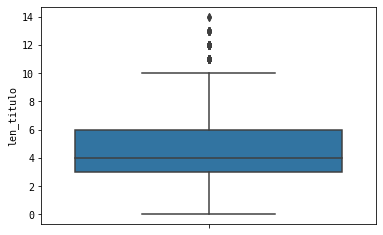

In [23]:
plot = sns.boxplot(df["len_titulo"], orient="v")

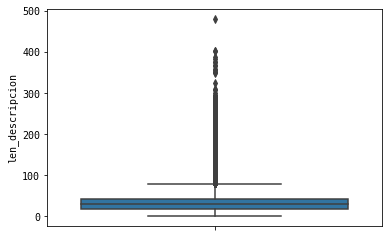

In [54]:
plot = sns.boxplot(df["len_descripcion"], orient="v")

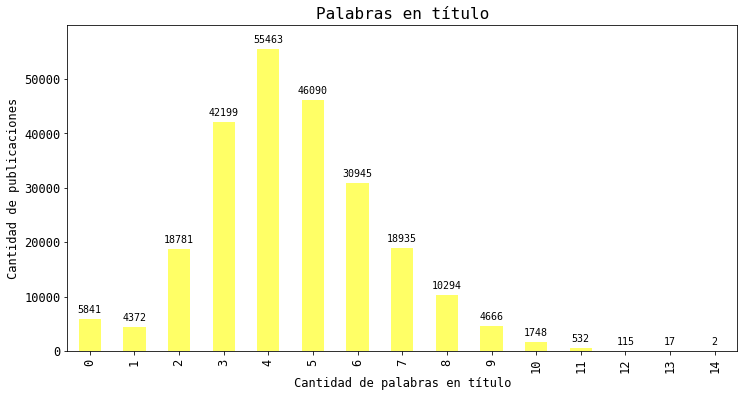

In [57]:
plot = get_barplot(df["len_titulo"].value_counts().sort_index(), title="Palabras en título", x_label="Cantidad de palabras en título", y_label="Cantidad de publicaciones")

In [61]:
plot.figure.savefig("../graficos/barplot_palabras_titulo.png")

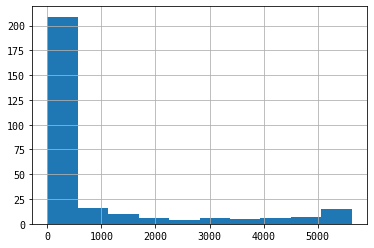

In [69]:
df["len_descripcion"].value_counts().sort_index().hist()

In [70]:
from collections import Counter

def get_word_counter(series):
    """
        Faltaría analizar stemming
    """
    counter = Counter()
    for title in series.values:
        counter.update(set(title.split()))
    return counter

In [71]:
titulo_palabras = get_word_counter(df["titulo_limpio"])
descripcion_palabras = get_word_counter(df["descripcion_limpia"])

In [105]:
print(len(titulo_palabras),len(descripcion_palabras))

18578 72121


In [ ]:
# titulo_palabras.most_common(10)

In [ ]:
# descripcion_palabras.most_common(10)

In [72]:
palabras_positivas = {"conservacion","tenis","balcon","panoramica","exclusivos","golf","canchas","remodelada","acondicionado","lujo","jacuzzi","diseno","exclusiva","magnifica","exclusivo","country","precioso","estilo","seguridad","verdes","juegos","servicio","excelente","terraza","jardin","hermosa","vista","bonita","renta", "granito"}
palabras_negativas = {"oportunidad","remato","oferta","remodelar"}

In [73]:
df["palabras_positivas_descripcion"] = df["descripcion_limpia"].map(lambda x: len([y for y in x.split() if y in palabras_positivas]))
df[["palabras_positivas_descripcion","precio"]].corr()

,palabras_positivas_descripcion,precio
palabras_positivas_descripcion,1.000000,0.338492
precio,0.338492,1.000000


In [74]:
df["palabras_negativas_descripcion"] = df["descripcion_limpia"].map(lambda x: len([y for y in x.split() if y in palabras_negativas]))
df[["palabras_negativas_descripcion","precio"]].corr()

,palabras_negativas_descripcion,precio
palabras_negativas_descripcion,1.000000,-0.026244
precio,-0.026244,1.000000


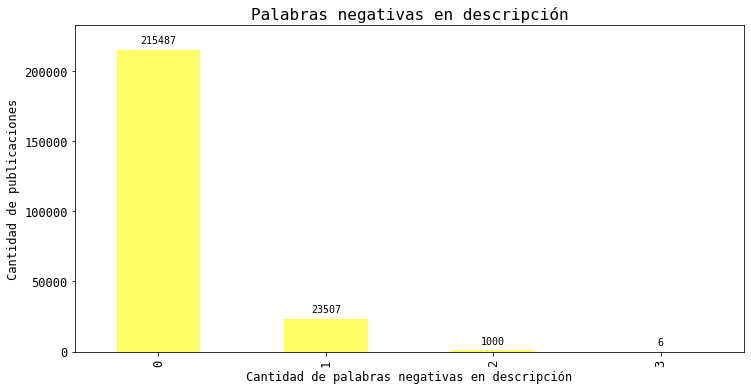

In [103]:
plot = get_barplot(df.palabras_negativas_descripcion.value_counts().sort_index(), title="Palabras negativas en descripción", x_label="Cantidad de palabras negativas en descripción", y_label="Cantidad de publicaciones")
plot.figure.savefig("../graficos/barplot_palabras_negativas_descripcion.png")

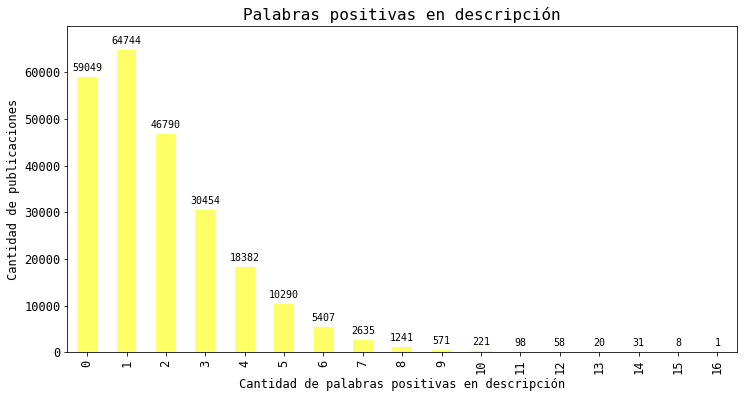

In [102]:
plot = get_barplot(df.palabras_positivas_descripcion.value_counts().sort_index(), title="Palabras positivas en descripción", x_label="Cantidad de palabras positivas en descripción", y_label="Cantidad de publicaciones")
plot.figure.savefig("../graficos/barplot_palabras_positivas_descripcion.png")

In [77]:
df_corr_positivas = df[["descripcion_limpia","precio"]]
for palabra in palabras_positivas:
    df_corr_positivas[palabra] = df_corr_positivas["descripcion_limpia"].map(lambda x: int(palabra in x))
df_corr_positivas.corr()["precio"].sort_values(ascending=False)

c:\users\dev\repos\fiuba\75-06\2019-2\tp\.venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


precio           1.000000
terraza          0.223338
jardin           0.208592
vista            0.194534
jacuzzi          0.157660
lujo             0.155200
juegos           0.144366
servicio         0.132612
granito          0.102580
estilo           0.099340
hermosa          0.097818
exclusivo        0.091339
panoramica       0.087759
precioso         0.086908
balcon           0.081591
tenis            0.073820
excelente        0.065813
golf             0.064149
seguridad        0.060509
exclusiva        0.055698
diseno           0.052607
country          0.051681
remodelada       0.051611
exclusivos       0.040721
magnifica        0.039993
conservacion     0.028719
renta            0.026840
acondicionado    0.022942
canchas          0.021226
verdes          -0.022241
bonita          -0.040270
Name: precio, dtype: float64

In [78]:
df_corr_negativas = df[["descripcion_limpia","precio"]]
for palabra in palabras_negativas:
    df_corr_negativas[palabra] = df_corr_negativas["descripcion_limpia"].map(lambda x: int(palabra in x))
df_corr_negativas.corr()["precio"].sort_values(ascending=True)

c:\users\dev\repos\fiuba\75-06\2019-2\tp\.venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


oportunidad   -0.042807
oferta        -0.031834
remato        -0.017778
remodelar      0.049695
precio         1.000000
Name: precio, dtype: float64

In [79]:
test = df[["descripcion_limpia","precio","metrostotales"]]
for palabra in palabras_positivas:
    test[palabra] = test["descripcion_limpia"].map(lambda x: int(palabra in x))

c:\users\dev\repos\fiuba\75-06\2019-2\tp\.venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
top = list(set(test.corr()["metrostotales"].sort_values(ascending=False).head(8).index).union(set(test.corr()["precio"].sort_values(ascending=False).head(8).index)))

In [85]:
test_corr = test[top].corr()
test_corr["dif"] = test_corr["precio"] - test_corr["metrostotales"]
test_corr["dif"] = abs(test_corr["dif"])

In [86]:
test_corr["dif"].sort_values(ascending=False)
#estas se me ocurre que serian las palabras que mayor diferencia podrian hacer

precio           0.485589
metrostotales    0.485589
juegos           0.078725
lujo             0.077370
vista            0.070146
jacuzzi          0.052263
terraza          0.038639
jardin           0.025931
granito          0.006427
hermosa          0.004686
Name: dif, dtype: float64

In [87]:
test_corr

,metrostotales,granito,jardin,hermosa,lujo,juegos,jacuzzi,vista,terraza,precio,dif
metrostotales,1.000000,0.109006,0.234522,0.102505,0.077831,0.065640,0.105397,0.124387,0.184700,0.514411,0.485589
granito,0.109006,1.000000,0.148632,0.080282,0.164585,0.055081,0.040159,0.094475,0.163145,0.102580,0.006427
jardin,0.234522,0.148632,1.000000,0.122408,0.071130,0.146598,0.102968,0.124513,0.207999,0.208592,0.025931
hermosa,0.102505,0.080282,0.122408,1.000000,0.067182,0.054155,0.047128,0.156207,0.096229,0.097818,0.004686
lujo,0.077831,0.164585,0.071130,0.067182,1.000000,0.046619,0.066057,0.107811,0.113100,0.155200,0.077370
juegos,0.065640,0.055081,0.146598,0.054155,0.046619,1.000000,0.109528,0.101708,0.111850,0.144366,0.078725
jacuzzi,0.105397,0.040159,0.102968,0.047128,0.066057,0.109528,1.000000,0.094428,0.120713,0.157660,0.052263
vista,0.124387,0.094475,0.124513,0.156207,0.107811,0.101708,0.094428,1.000000,0.191207,0.194534,0.070146
terraza,0.184700,0.163145,0.207999,0.096229,0.113100,0.111850,0.120713,0.191207,1.000000,0.223338,0.038639
precio,0.514411,0.102580,0.208592,0.097818,0.155200,0.144366,0.157660,0.194534,0.223338,1.000000,0.485589


In [88]:
con_descripcion_y_titulo = df.loc[(df["len_descripcion"]>0) & (df["len_titulo"]>0)]

In [89]:
con_descripcion_y_titulo["titulo_descripcion"] = con_descripcion_y_titulo["titulo_limpio"] + "_" + con_descripcion_y_titulo["descripcion_limpia"]
con_descripcion_y_titulo["tiene_duplicado"] = con_descripcion_y_titulo["titulo_descripcion"].duplicated(keep=False)

c:\users\dev\repos\fiuba\75-06\2019-2\tp\.venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\dev\repos\fiuba\75-06\2019-2\tp\.venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [90]:
duplicadas = con_descripcion_y_titulo.loc[con_descripcion_y_titulo["tiene_duplicado"]].sort_values(by="titulo_descripcion")

In [91]:
grouped = duplicadas.groupby(["titulo_descripcion"]).agg({"fecha":"nunique", "precio": ["nunique", "mean", "max", "min"]})

In [92]:
grouped.columns = [x+"_"+y for x,y in grouped.columns]

In [93]:
grouped["precio_dif"] = (grouped["precio_max"] - grouped["precio_min"]).astype(int)

In [94]:
grouped["precio_dif"].describe()

count    2.146000e+03
mean     3.189765e+05
std      7.286901e+05
min      0.000000e+00
25%      0.000000e+00
50%      7.001500e+04
75%      3.000000e+05
max      1.131212e+07
Name: precio_dif, dtype: float64

In [95]:
grouped.loc[grouped["precio_dif"]>grouped["precio_dif"].mean()].sort_values(by="precio_nunique", ascending=False)

,fecha_nunique,precio_nunique,precio_mean,precio_max,precio_min,precio_dif
titulo_descripcion,,,,,,
venta casa tijuana_manzana nocnok vivienda encuentra lote,11,38,5.366581e+05,820000.0,310808.0,509192
venta casa chihuahua_ningun nocnok venta exclusiva tipo posesion contado fisica acepta credito,6,16,4.929856e+05,895730.0,318696.0,577034
venta zapopan terreno lote_rapido vapor pista multiusos jogging basquet canchas cuenta nivel vip planta fraccionamiento arauca segundo areas casa juegos salon club metros olimpica semi gimnasio vestidores cine squash amplia cancha alberca terreno terraza baja fut voley lote manzana sala mas etapa residencial dos tenis verdes sauna,6,14,2.369864e+06,2913790.0,1823000.0,1090790
placita sahuaros local_ciudad muros extractor aire area centimetros fachada cuenta marquesina banquetas medio pisos aluminio plaza ventaneria norte columnas agua tuboplus excelente puerta cubiertas concreto instalacion nueva amplia carpeta ceramica aplanados bano estacionamiento comercial asfaltica local tinaco metalica adeblock guarniciones enrollable,4,13,7.737869e+05,1708350.0,479500.0,1228850
remate chihuahua hipotecario_pueden pago realidad descripcion garantia publico creditos adjudicatarios oportunidades condiciones avaluo inmobiliaria diferencias media empresa ubicacion derechos explicamos buenas superficies inversion imagenes dedicada registro segura grandes preocupes representar presentadas litigiosos sino venta cesiones unicamente sabes hipotecario crediticios exactitud hipotecaria debajo aqui notario remate contado relacion numeracion tener,2,13,8.024475e+05,1805692.0,334391.0,1471301
...,...,...,...,...,...,...
narvarte venta col departamento pre_marmol vigilancia aquitectura ordenes vivir bienes recamaras sujeto converte cada multiusos modernos cuenta terrazas www pisos estudio cubierta edificio jacuzzi asador salon cambio viernes elevador deptos precio gimnasio bodegas sabados biselados desarrollo cocinas lunes oficina calidad unicamente bano estacionamiento interiores madera zona recamara unica aviso closets cajones departamentos acabados mayor granito cuentan opcion completos residencial vestidor principal amenidades disponiblidad hrs laminados banos previo,1,2,3.480000e+06,3720000.0,3240000.0,480000
nacional casa secc esquina himno_recamaras cocina medio nivel planta casa integral cuarto estancia techada comedor alta plantas autos afuera bano cochera completo sala hall servicio banos,2,2,2.000000e+06,2300000.0,1700000.0,600000
morelos venta cuajimalpa departamento_spa recamaras city estacionamientos cuenta comunes estrene areas guarderia salones usos torre techada gimnasio desarrollo hermoso depto alberca multiples santa acabados lujo milan excelentes banos,1,2,5.340000e+06,5630000.0,5050000.0,580000


In [96]:
con_descripcion_y_titulo.loc[con_descripcion_y_titulo["titulo_descripcion"]=="venta casa tijuana_lote manzana nocnok encuentra vivienda"].head(2)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia,precio_metro_cubierto,precio_metro_total,gps,descripcion_limpia,len_descripcion,titulo_limpio,len_titulo,palabras_positivas_descripcion,palabras_negativas_descripcion,titulo_descripcion,tiene_duplicado


In [97]:
con_descripcion_y_titulo.loc[con_descripcion_y_titulo["titulo_descripcion"]=="venta casa chihuahua_nocnok tipo credito contado venta posesion fisica ningun acepta exclusiva"].head(2)

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia,precio_metro_cubierto,precio_metro_total,gps,descripcion_limpia,len_descripcion,titulo_limpio,len_titulo,palabras_positivas_descripcion,palabras_negativas_descripcion,titulo_descripcion,tiene_duplicado
